In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import os
from os import listdir
from os.path import isfile, join
from enum import Enum
%load_ext autoreload
%autoreload 2
from ExtractInfoFromGrid import *
from DatasetVisualization import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
def allExamplesOfSameDimension (train_list):
    for example in train_list:
        ip = example['input']
        op = example['output']
        if (np.array(ip).shape != np.array(train_list[0]['input']).shape or
            np.array(op).shape != np.array(train_list[0]['output']).shape):
            return False
        
    return True

mypath = '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/'
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
files.sort()
k = 0
batch_size = len(files)
start = k * batch_size
end = start + batch_size
#random_order = np.random.permutation(batch_size)
random_order = np.arange(batch_size)
random_files = [files[idx] for idx in random_order]

random_files_consistent_size = []
for filename in random_files:
    train_list, test_list = read_single_training_example(filename)
    if (not allExamplesOfSameDimension(train_list)):
        continue
    random_files_consistent_size.append(filename)
print('Total files are ' + str(len(random_files_consistent_size)))

Total files are 26


In [7]:
random_files_consistent_size

['../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/045e512c.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/0962bcdd.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/1b60fb0c.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/1bfc4729.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/1e32b0e9.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/2281f1f4.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/25ff71a9.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/29c11459.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/3906de3d.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/3aa6fb7a.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/3befdf3e.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/4093f84a.json',
 '../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Color

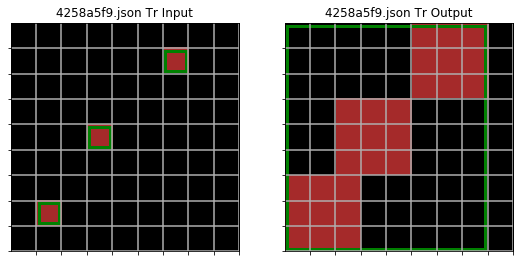

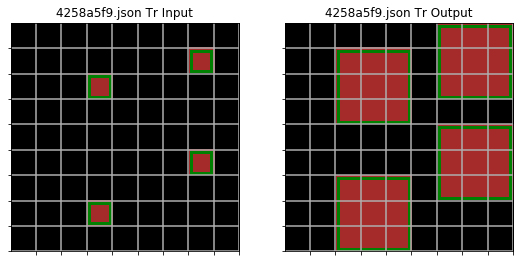

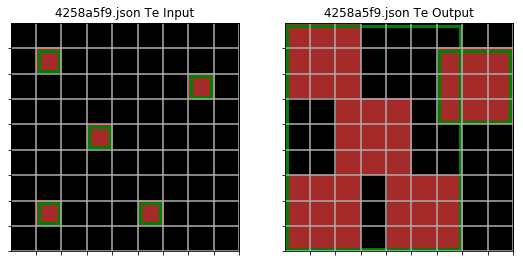

In [11]:
exampleFile = [random_files_consistent_size[12]]
for filename in exampleFile:
    train_list, test_list = read_single_training_example(filename)
    show_single_training_example_visually(train_list, test_list, filename, removeColorAsp=True)

In [29]:
def augmentData(jsonFilePath, removeColorAsp):
    train_list, test_list = read_single_training_example(filename)
    training_data = []
    for pair in train_list:
        inp = np.array(pair['input'])
        op = np.array(pair['output'])
        if removeColorAsp == True:
            #There should be 2 colors only. Lets say ON and OFF
            ON = 9
            OFF = 0
            inp[inp != 0] = ON
            op[op != 0] = ON
            assert np.logical_or(inp == ON, inp == OFF).all() == True, "It should have only 2 type of values"
            assert np.logical_or(op == ON, op == OFF).all() == True, "It should have only 2 type of values"
            for newON in np.arange(10):
                for newOFF in np.arange(10):
                    if (newON == newOFF):
                        continue
                    newInp = np.zeros(inp.shape)
                    newInp[inp == ON] = newON
                    newInp[inp == OFF] = newOFF
                    newOp = np.zeros(op.shape)
                    newOp[op == ON] = newON
                    newOp[op == OFF] = newOFF
                    #We have a pair newIn -> newOp
                    training_data.append({'input': newInp, 'output': newOp})
    
    test_data = test_list #As it is
    return training_data, test_data

In [31]:
jsonFilePath = random_files_consistent_size[12]
training_data, test_data = augmentData(jsonFilePath, True)
#print(len(training_data))
#print(training_data)

In [ ]:
class ARC(nn.Module):
    def __init__(self):
        super(ARC, self).__init__()
        self.conv3x3_0 = nn.Conv2d(1, 1, 3, padding=1)
        self.sigmoid_0 = nn.Sigmoid()
    
    def forward(self, inputs):
        outputs = self.conv3x3_0(inputs)
        outputs = self.sigmoid_0(outputs)
        return outputs

In [134]:
# def collateExamples(example_list):
#     ips = []
#     ops = []
#     for example in example_list:
#         ips.append(example['input'])
#         ops.append(example['output'])
#     temp = np.array(ips)
#     batched_inp = np.reshape(temp, (temp.shape[0],-1))
#     temp = np.array(ops)
#     batched_op = np.reshape(temp, (temp.shape[0],-1))
#     return batched_inp, batched_op

# class ARC(nn.Module):
#     def __init__(self, numCellsInput):
#         super(ARC, self).__init__()
     
#         flattened_dim = numCellsInput
#         self.LL = nn.Linear(flattened_dim, flattened_dim, bias=False)

#     def allExamplesOfSameDimension (self):
#         for example in self.train_list:
#             ip = example['input']
#             op = example['output']
#             if (np.array(ip).shape != np.array(train_list[0]['input']).shape or
#                 np.array(op).shape != np.array(train_list[0]['output']).shape):
#                 return False

#         return True
    
#     def forward(self, inputs, VAL1, VAL2):
#         probs = torch.sigmoid(self.LL(inputs))
# #         ft = torch.zeros(probs.size())
# #         ft[probs >= 0.5] = 1.0
# #         ft[probs < 0.5] = 0.0
# #         ft_ = torch.zeros(probs.size())
# #         ft_[probs >= 0.5] = 0.0
# #         ft_[probs < 0.5] = 1.0
# #         inputs_ = inputs.clone()
# #         inputs_[inputs == VAL1] = VAL2 * 1.0
# #         inputs_[inputs == VAL2] = VAL1 * 1.0
# #         op = ft * inputs + ft_ * inputs_
#         op = inputs + probs * inputs
#         return op
    
#     def loss(this, y, y_pred):
#         p = (y != y_pred).sum().type(torch.float)
#         p.requires_grad = True
#         return p
    
#     def handleColorAspect(filename, removeColorAsp):
#         train_list, test_list = read_single_training_example(filename)
#         bTrain_inp, bTrain_op = collateExamples(train_list)
#         bTest_inp, bTest_op = collateExamples(test_list)

#         if (removeColorAsp):
#             bTrain_inp[bTrain_inp != 0] = 9
#             bTrain_op[bTrain_op != 0] = 9
#             bTest_inp[bTest_inp != 0] = 9
#             bTest_op[bTest_op != 0] = 9 
            
#         A = np.unique(bTrain_inp)
#         B = np.unique(bTest_inp)
#         uniq_Values = np.unique(np.array([A, B]))
#         assert len(uniq_Values) == 2
#         VAL1 = uniq_Values[0]
#         VAL2 = uniq_Values[1]
#         return bTrain_inp, bTrain_op, bTest_inp, bTest_op, VAL1, VAL2
    
# def train(filename, removeColorAsp):

#     bTrain_inp, bTrain_op, bTest_inp, bTest_op, VAL1, VAL2 = ARC.handleColorAspect(filename, removeColorAsp)
#     model = ARC(bTrain_inp.shape[1])
#     model.train()
#     X = Variable(torch.Tensor(bTrain_inp))
#     X.requires_grad = False
#     y = Variable(torch.Tensor(bTrain_op))
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
#     criterian = torch.nn.MSELoss()
#     for it in np.arange(10):
#         print(model.LL.weight)
#         y_pred = model(X, VAL1, VAL2)
#         loss = model.loss(y, y_pred)
#         #loss = criterian(y, y_pred)
#         #loss.requires_grad = True
        
#         print(f'it: {it}, loss: {loss}')
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()     
#         #print(model.LL.weight)
#     return

# train(random_files_consistent_size[-9], True)

Parameter containing:
tensor([[-0.0052,  0.3258,  0.3182, -0.1395,  0.0302,  0.1585,  0.2707, -0.0672,
         -0.1143],
        [-0.1484,  0.2899,  0.0320,  0.1650,  0.0174, -0.1379,  0.1011, -0.2345,
         -0.3314],
        [-0.0800,  0.1107, -0.0695,  0.2663,  0.3250, -0.3320,  0.2790,  0.1705,
          0.1215],
        [-0.0576,  0.2013, -0.0821,  0.2761, -0.2019,  0.1926, -0.0301, -0.0646,
         -0.0938],
        [-0.0461,  0.3081, -0.1893,  0.2693, -0.1092, -0.2674, -0.2047,  0.0671,
          0.1970],
        [-0.1944,  0.3172,  0.2286,  0.0528,  0.2757,  0.1682,  0.0214,  0.1242,
          0.0225],
        [-0.0024, -0.0249, -0.1413, -0.0835,  0.1082, -0.1648, -0.0959, -0.2034,
          0.2261],
        [-0.1835, -0.0682, -0.2183,  0.2939, -0.2585, -0.0180,  0.1303,  0.0915,
          0.1739],
        [-0.3238,  0.3221, -0.1728, -0.0452, -0.0731,  0.2222, -0.0280, -0.1694,
          0.2513]], requires_grad=True)
it: 0, loss: 22.0
Parameter containing:
tensor([[-0.0052,

In [24]:
x = np.zeros(9).reshape(3,3)
print(x)
np.logical_or(x == 0, x == 8).all()

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


True

In [102]:
model.LL.weight

Parameter containing:
tensor([[ 0.0389, -0.0320, -0.0321,  ..., -0.0572,  0.0554, -0.0883],
        [ 0.0858, -0.0224, -0.0712,  ..., -0.0141,  0.0948,  0.0283],
        [ 0.0529, -0.0131, -0.0321,  ...,  0.0546, -0.0557,  0.0445],
        ...,
        [-0.0523, -0.0430,  0.0216,  ..., -0.0615, -0.0058, -0.0284],
        [-0.0069,  0.0212, -0.0321,  ...,  0.0630, -0.0496,  0.0878],
        [-0.0652, -0.0733,  0.0134,  ..., -0.0646,  0.0572, -0.0052]],
       requires_grad=True)

In [80]:
t1 = torch.Tensor([[1,2,3],[4,5,6]])
t2 = torch.Tensor([[2,2,3],[4,5,7]])
print(t1)
print(t2)
print((t1 != t2).sum())

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([[2., 2., 3.],
        [4., 5., 7.]])
tensor(2)


In [96]:
random_files_consistent_size[-9]

'../ARC_Dataset/mini_training/OP_EQUAL_IP/Non Colored Dataset/25ff71a9.json'